# Coursework 3: Part B - GNNs

#### Instructions

Please submit on CATe a zip file named *CW3_GNNs.zip* containing a version of this notebook containing your answers. Write your answers in the cells below each question.


#### Working environment:

Similarly to the previous coursework, we recommend that you use Google Colaboratory in order to train the required networks.

**The deadline for submission is 19:00, Thursday 12th March, 2020**

## Graph neural networks coursework

This coursework is separated into a coding and a theory component.



### Part 1 - Coding (70%)
In this part you will have to:

#### Part 1.1 (40%)

Implement the Graph Convolutional Networks [Kipf & Welling](http://arxiv.org/abs/1609.02907) (ICLR 2017).

#### Part 1.2 (30%)

Implement the Graph Attentional Networks ([Veličković et al.](https://arxiv.org/abs/1710.10903) (ICLR 2018)).


### Part 2 - Theory (30%)

Here you will answer some theoretical questions about graph attentional networks -- no detailed proofs and no programming.

# Part 1: Coding (70%)

This coursework is partially based on the repo created by Bumsoo Kim, Ph.D Candidate in Korea University: https://github.com/tkipf/pygcn](https://github.com/tkipf/pygcn).

## Graph Convolutional Networks

As we explained in the tutorial, most graph neural network models have a somewhat universal architecture in common. They are referred as Graph Convoutional Networks (GCNs) since filter parameters are typically shared over all locations in the graph.

For these models, the goal is to learn a function of signals/features on a graph $\mathcal{G}=(\mathcal{V}, \mathcal{E})$ with $N$ nodes $v_i \in \mathcal{V}$, edges $(v_i,v_j)\in \mathcal{V}$. This graph takes as:

**Input**
- $N \times D$ feature matrix ($N$ : Number of nodes, $D$ : number of features per node)
- Representative description of the graph structure in matrix form; typically in the form of $N \times N$ adjacency matrix $A$

**Output**
- $N \times F$ feature matrix ($N$ : Number of nodes, $F$ : number of output features)

Graph-level outputs can be modeled by introducing some form of pooling operation.


For more details, see [here](https://tkipf.github.io/graph-convolutional-networks/).



## Transductive learning on citation networks
In this coursework, we use an implementation of Planetoid, a graph-based semi-supervised learning framework proposed in the following paper: [Revisiting Semi-Supervised Learning with Graph Embeddings](https://arxiv.org/abs/1603.08861).

This dataset is consisted of 3 sub-datasets ('pubmed', 'cora', 'citeseer'). Specifically, we will be working with the *Cora* citation network ([Sen et al.](http://eliassi.org/papers/ai-mag-tr08.pdf)) for the task of transductive node classification, which contains $2,708$ nodes, $5,429$ edges, $7$ classes and $1,433$ features per node. We will use $140$ instances for training, $500$ for validation, and $1,000$ for testing.

Each node in the dataset represents a document, and the edge represents the 'reference' relationship between the documents.

For more details, see [here](https://github.com/kimiyoung/planetoid).

In [1]:
from IPython.display import Image, display
display(Image(filename='gcn_web.png', width=850))

FileNotFoundError: ignored

Set-up code and imports:

In [0]:
import math
import time
import random
import sys
import os
import numpy as np
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
use_gpu = torch.cuda.is_available() # if you have available GPUs...

if use_gpu:
    torch.cuda.manual_seed_all(42)

## Part 1.1: GCNs (40%)

### Pre-processing

First of all, download the planetoid dataset in the "data" folder from https://github.com/kimiyoung/planetoid and assign to *dataroot* the directory to the downloaded dataset. 

In [0]:
# !git clone https://github.com/kimiyoung/planetoid.git
dataroot = './planetoid/data' # absolute path where we have stored the datasets

We recall the propagation rule introduced in [Kipf & Welling](http://arxiv.org/abs/1609.02907) (ICLR 2017):

$$
H^{(l+1)} = \sigma\left( \tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}H^{(l)}W^{(l)}\right),
$$

where $\sigma(\cdot)$ denotes the activation function. Therefore, we need first to compute the filter $\tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}$, wich will be constant across the different layers of the GCN:

- $\tilde{A}=A+I_N$ is the adjacency matrix of the undirected graph $\mathcal{G}$ with added self-connections. $I_N$ is the identity matrix
- $\tilde{D}_{ii}=\sum_j \tilde{A}_{ij}$ is the degree matrix of $\mathcal{G}$ with added self-connections

Now it is your turn to compute the aforementioned filter from the adjacency matrix $A$. To improve numerical stability, after computing $\tilde{D}^{-\frac{1}{2}}$ we recommend:
1. Check if $\tilde{D}^{-\frac{1}{2}}$ has infinity values and substitute them by zero
2. From the resulting matrix, create a sparse matrix based on its diagonal elements.
3. Compute $\tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}$
4. Or you can use your imagination to solve this

In [0]:
def normalize_adj(adj):
    ########################################################################
    ## START OF YOUR CODE
    ########################################################################
    
    rowsum = np.array(adj.sum(1))
    r_inv_sqrt = np.power(rowsum, -0.5).flatten()
    r_inv_sqrt[np.isinf(r_inv_sqrt)] = 0.
    r_mat_inv_sqrt = sp.diags(r_inv_sqrt) 
    
    adj = adj.dot(r_mat_inv_sqrt).transpose().dot(r_mat_inv_sqrt)        

    ########################################################################
    ## END OF YOUR CODE
    ########################################################################

    return adj.tocoo()

Next we define a function to (row-)normalize the input feature vectors, as in [Kipf & Welling](http://arxiv.org/abs/1609.02907) (ICLR 2017):


$$
\tilde{X}=  D_X^{-1}X,
$$
where $D_{X,ii}=\sum_jX_{ij}$

Again, you should:
1. Check that $D_X^{-1}$ has infinity values and substitute them by zero
2. From the resulting matrix, create a sparse matrix based on its diagonal elements.
3. Compute $D_X^{-1}X$
4. Or you can use your imagination to solve this

In [0]:
def normalize_feat(features):
    
    ########################################################################
    ## START OF YOUR CODE
    ########################################################################
    
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)

    ########################################################################
    ## END OF YOUR CODE
    ########################################################################
    
    return features

We will use this normalise version of features as the input for the graph. Next, we can pre-process the graph data. You are expected to normalise the adjacency matrix and the features.

In [61]:
def load_data(path=dataroot, dataset="cora"):
    """
    x     => the feature vectors of the training instances (scipy.sparse.csr.csr_matrix)
    y     => the one-hot labels of the labeled training instances (numpy.ndarray)
    tx => the feature vectors of the test instances (scipy.sparse.csr.csr_matrix)
    ty => the one-hot labels of the test instances (numpy.ndarray)
    allx  => the feature vectors of both labeled and unlabeled training instances (csr_matrix)
    ally  => the labels for instances in ind.dataset_str.allx (numpy.ndarray)
    graph => the dict in the format {index: [index of neighbor nodes]} (collections.defaultdict)
    """
    print("\n[STEP 1]: Upload {} dataset.".format(dataset))

    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []

    for i in range(len(names)):
        print("{}/ind.{}.{}".format(path, dataset, names[i]))
        with open("{}/ind.{}.{}".format(path, dataset, names[i]), 'rb') as f:
            
            u = pkl._Unpickler(f)
            u.encoding = 'latin1'
            p = u.load()
            objects.append(p)

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    
    test_idx_reorder = []

    for line in open("{}/ind.{}.test.index".format(path, dataset)):
        test_idx_reorder.append(int(line.strip()))

    test_idx_range = np.sort(test_idx_reorder)

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))    
    
    ########################################################################
    ## START OF YOUR CODE
    ########################################################################
    
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))
    adj = normalize_adj(adj + sp.eye(adj.shape[0]))
    
    features = normalize_feat(features)

    ########################################################################
    ## END OF YOUR CODE
    ########################################################################
    
    print("| # of nodes : {}".format(adj.shape[0]))
    print("| # of edges : {}".format(adj.sum().sum()/2))
    print("| # of features : {}".format(features.shape[1]))
    print("| # of clases   : {}".format(ally.shape[1]))

    features = torch.FloatTensor(np.array(features.todense()))
    sparse_mx = adj.tocoo().astype(np.float32)
    adj = torch.FloatTensor(np.array(adj.todense()))

    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]
    labels = torch.LongTensor(np.where(labels)[1])

    idx_train = range(len(y))
    idx_val = range(len(y), len(y)+500)
    idx_test = test_idx_range.tolist()

    print("| # of train set : {}".format(len(idx_train)))
    print("| # of val set   : {}".format(len(idx_val)))
    print("| # of test set  : {}".format(len(idx_test)))

    idx_train, idx_val, idx_test = list(map(lambda x: torch.LongTensor(x), [idx_train, idx_val, idx_test]))

    return adj, features, labels, idx_train, idx_val, idx_test


def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

dataset = load_data()


[STEP 1]: Upload cora dataset.
./planetoid/data/ind.cora.x
./planetoid/data/ind.cora.y
./planetoid/data/ind.cora.tx
./planetoid/data/ind.cora.ty
./planetoid/data/ind.cora.allx
./planetoid/data/ind.cora.ally
./planetoid/data/ind.cora.graph
| # of nodes : 2708
| # of edges : 1252.6696352573126
| # of features : 1433
| # of clases   : 7
| # of train set : 140
| # of val set   : 500
| # of test set  : 1000


### Graph Convolution

Here you are required to implement the basic convolution operator of the GCN.

In [63]:
class GraphConvolution(Module):
    def __init__(self, in_features, out_features, bias=True, init='xavier'):
        super(GraphConvolution, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        if init == 'uniform':
            print("| Uniform Initialization")
            self.init_uniform()
        elif init == 'xavier':
            print("| Xavier Initialization")
            self.init_xavier()
        else:
            raise NotImplementedError
            

    def init_uniform(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def init_xavier(self):
        nn.init.xavier_normal_(self.weight.data, gain=0.02) # Implement Xavier Uniform
        if self.bias is not None:
            nn.init.constant_(self.bias.data, 0.0)

    def forward(self, input, adj):
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        
        weighted_features = input @ self.weight
        output = torch.spmm(adj, weighted_features)

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

adj, features, labels, idx_train, idx_val, idx_test = dataset
gcon = GraphConvolution(features.shape[1], 100)
gcon(features[:10], adj[:10,:10]).shape

| Xavier Initialization


torch.Size([10, 100])

### GCN Model

Complete the GCN Model with one hidden layer with dropout, and the output layer:

In [0]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, init):
        super(GCN, self).__init__()
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        
        self.conv1 = GraphConvolution(nfeat, nhid, init=init)
        self.conv2 = GraphConvolution(nhid, nclass, init=init)
        self.drop = dropout

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

    def forward(self, x, adj):
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        
        x = F.dropout(torch.relu(self.conv1(x, adj)), self.drop, training=self.training)
        x = self.conv2(x, adj)

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        return F.log_softmax(x, dim=1)

### Training


First, we define the training procedure.

In [0]:
def lr_scheduler(epoch, lr, lr_decay_epoch):
    return lr * (0.5 ** (epoch / lr_decay_epoch))

# Train
def train(model, model_type, adj, features, labels, idx_train, idx_val, optimizer, epoch, lr, lr_decay_epoch, save_point):
    global best_acc

    t = time.time()
    model.train()
    optimizer.lr = lr_scheduler(epoch, lr, lr_decay_epoch)
    optimizer.zero_grad()

    ########################################################################
    ## START OF YOUR CODE
    ########################################################################
    
    preds = model(features, adj)
    loss_train = F.nll_loss(preds[idx_train], labels[idx_train])
    acc_train = accuracy(preds[idx_train], labels[idx_train])

    loss_train.backward()
    ########################################################################
    ## END OF YOUR CODE
    ########################################################################    

    optimizer.step()

    # Validation for each epoch
    model.eval()
    output = model(features, adj)
    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])

    if acc_val > best_acc:
        best_acc = acc_val
        state = {
            'model': model,
            'acc': best_acc,
            'epoch': epoch,
        }
        
        torch.save(state, os.path.join(save_point, '%s.t7' %(model_type)))

    sys.stdout.flush()
    sys.stdout.write('\r')
    sys.stdout.write("=> Training Epoch #{} : lr = {:.4f}".format(epoch, optimizer.lr))
    sys.stdout.write(" | Training acc : {:6.2f}%".format(acc_train.data.cpu().numpy() * 100))
    sys.stdout.write(" | Best acc : {:.2f}%". format(best_acc.data.cpu().numpy() * 100))

Next we run the training.

In [74]:
dataset = 'cora'
num_hidden = 8 # number of features
dropout = 0.6 # dropout
weight_decay = 5e-4 # weight decay
init_type = 'xavier' # [uniform | xavier]
        
lr = 5e-3 # initial learning rate
optimizer_type = 'adam' # [sgd | adam]
epoch = 800 # number of training epochs
lr_decay_epoch = 5000 # multiply by a gamma every set iter
alpha = 0.2 # Alpha value for the leaky_relu'


# Data upload
adj, features, labels, idx_train, idx_val, idx_test = load_data(path=dataroot, dataset=dataset)

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if use_gpu:
    torch.cuda.manual_seed(42)

optimizer = None
best_acc = 0


print("| Constructing basic GCN model...")
model = GCN(
        nfeat = features.shape[1],
        nhid = num_hidden,
        nclass = labels.max().item() + 1,
        dropout = dropout,
        init = init_type
)


if (optimizer_type == 'sgd'):
    optimizer = optim.SGD(
            model.parameters(),
            lr = lr,
            weight_decay = weight_decay,
            momentum = 0.9
    )
elif (optimizer_type == 'adam'):
    optimizer = optim.Adam(
            model.parameters(),
            lr = lr,
            weight_decay = weight_decay
    )
else:
    raise NotImplementedError

if use_gpu:
    model.cuda()
    features, adj, labels, idx_train, idx_val, idx_test = \
        list(map(lambda x: x.cuda(), [features, adj, labels, idx_train, idx_val, idx_test]))

features, adj, labels = list(map(lambda x : Variable(x), [features, adj, labels]))

if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')

save_point = os.path.join('./checkpoint', dataset)

if not os.path.isdir(save_point):
    os.mkdir(save_point)


# Main code for training
if __name__ == "__main__":
    print("\n[STEP 2] : Obtain (adjacency, feature, label) matrix")
    print("| Adjacency matrix : {}".format(adj.shape))
    print("| Feature matrix   : {}".format(features.shape))
    print("| Label matrix     : {}".format(labels.shape))

    # Training
    print("\n[STEP 3] : Training")
    for epoch in range(1, epoch+1):
        train(model, 'gcn', adj, features, labels, idx_train, idx_val, optimizer, epoch, lr, lr_decay_epoch, save_point)
    print("\n=> Training finished!")


[STEP 1]: Upload cora dataset.
./planetoid/data/ind.cora.x
./planetoid/data/ind.cora.y
./planetoid/data/ind.cora.tx
./planetoid/data/ind.cora.ty
./planetoid/data/ind.cora.allx
./planetoid/data/ind.cora.ally
./planetoid/data/ind.cora.graph
| # of nodes : 2708
| # of edges : 1252.6696352573126
| # of features : 1433
| # of clases   : 7
| # of train set : 140
| # of val set   : 500
| # of test set  : 1000
| Constructing basic GCN model...
| Xavier Initialization
| Xavier Initialization

[STEP 2] : Obtain (adjacency, feature, label) matrix
| Adjacency matrix : torch.Size([2708, 2708])
| Feature matrix   : torch.Size([2708, 1433])
| Label matrix     : torch.Size([2708])

[STEP 3] : Training
=> Training Epoch #800 : lr = 0.0045 | Training acc :  95.00% | Best acc : 79.40%
=> Training finished!


### Test


First, we define the test function.

In [0]:
def test(model, adj, features, labels, idx_test):
    print("\n[STEP 4] : Testing")
    
    ########################################################################
    ## START OF YOUR CODE
    ########################################################################
    
    model.eval()
    output = model(features, adj)
    acc_test = accuracy(output[idx_test], labels[idx_test])

    ########################################################################
    ## END OF YOUR CODE
    ########################################################################
    
    print(output[idx_test].shape)
    print(labels[idx_test].shape)

    print("| Validation acc : {}%".format(acc_val.data.cpu().numpy() * 100))
    print("| Test acc : {}%\n".format(acc_test.data.cpu().numpy() * 100))

Next, we evaluate the performance of the model on unseen graphs.

In [78]:
adj, features, labels, idx_train, idx_val, idx_test = load_data(path=dataroot, dataset=dataset)

print("\n[STEP 2] : Obtain (adjacency, feature, label) matrix")
print("| Adjacency matrix : {}".format(adj.shape))
print("| Feature matrix   : {}".format(features.shape))
print("| Label matrix     : {}".format(labels.shape))

load_model = torch.load(os.path.join('./checkpoint', dataset, '%s.t7' %('gcn')))
model = load_model['model'].cpu()
acc_val = load_model['acc']

if use_gpu:
    _, features, adj, labels, idx_test = \
            list(map(lambda x: x.cuda(), [model, features, adj, labels, idx_test]))


if __name__ == "__main__":
    test(model, adj, features, labels, idx_test)


[STEP 1]: Upload cora dataset.
./planetoid/data/ind.cora.x
./planetoid/data/ind.cora.y
./planetoid/data/ind.cora.tx
./planetoid/data/ind.cora.ty
./planetoid/data/ind.cora.allx
./planetoid/data/ind.cora.ally
./planetoid/data/ind.cora.graph
| # of nodes : 2708
| # of edges : 1252.6696352573126
| # of features : 1433
| # of clases   : 7
| # of train set : 140
| # of val set   : 500
| # of test set  : 1000

[STEP 2] : Obtain (adjacency, feature, label) matrix
| Adjacency matrix : torch.Size([2708, 2708])
| Feature matrix   : torch.Size([2708, 1433])
| Label matrix     : torch.Size([2708])

[STEP 4] : Testing
torch.Size([1000, 7])
torch.Size([1000])
| Validation acc : 79.4%
| Test acc : 81.10000000000001%



## Part 1.2: GATs (30%)

### Graph Attention Networks

We suggest the students to study and understand the equations for the attention mechanism in GNNs introduced in [Veličković et al.](https://arxiv.org/abs/1710.10903) (ICLR 2018), and also described in https://petar-v.com/GAT/ .

Consider a graph of $N$ nodes, specified as a set of node features, $\left( \vec{h}_1, \vec{h}_2, \dots, \vec{h}_N \right), \vec{h}_i \in \mathbb{R}^F$. A graph convolutional layer then computes a set of new node features, $\left( \vec{h}'_1, \vec{h}'_2, \dots, \vec{h}'_N \right), \vec{h}'_i \in \mathbb{R}^{F'}$, based on the input features as well as the graph structure. Every graph convolutional layer starts off with a shared node-wise feature transformation (in order to achieve a higher-level representation), specified by a weight matrix $\bf W\in \mathbb{R}^{\textit{F}' \times \textit{F}}$. This transforms the feature vectors into $\vec{g}_i = {\bf W}\vec{h}_i$. After this, the vectors $\vec{g}_i $ are typically recombined in some way at each node.

In general, to satisfy the localisation property, we can define a graph convolutional operator as an aggregation of features across neighbourhoods; defining $\mathcal{N}_i$ as the neighbourhood of node $i$ (typically consisting of all first-order neighbours of $i$, including $i$ itself), we can define the output features of node $i$ as:

$$
\vec{h}'_i = \sigma\left(\sum_{j\in\mathcal{N}_i}\alpha_{ij}\vec{g}_j\right),
$$

where $\alpha_{ij}$ specifies the weighting factor (importance) of node $j$'s features to node $i$. Generally, we let $\alpha_{ij}$ be computed as a byproduct of an attentional mechanism, $a : \mathbb{R}^N \times \mathbb{R}^N \rightarrow \mathbb{R}$, which computes unnormalised coefficients $e_{ij}$ across pairs of nodes $i,j$, based on their features:

$$
e_{ij} = a\left( \vec{h}_i, \vec{h}_j \right).
$$

The graph structure is injected by only allowing node $i$ to attend over nodes in its first-order neighbourhood, $j\in \mathcal{N}_i$. These coefficients are then typically normalised using the softmax function, in order to be comparable across different neighbourhoods:

$$
\alpha_{ij} = \frac{\exp(e_{ij})}{\sum_{k\in\mathcal{N}_i}\exp(e_{ik})}.
$$

In  [Veličković et al.](https://arxiv.org/abs/1710.10903), the  attention  mechanism $a$ is a  single-layer  feedforward  neural  network, parametrised by a weight vector $\vec{{\bf a}}\in \mathbb{R}^{2F'}$, and applying the LeakyReLU nonlinearity (with negative input slope $\alpha= 0.2$).  Fully expanded out, the coefficients computed by the attention mechanism are then be expressed as:



$$
\alpha_{ij} = \frac{\exp\left(\text{LeakyReLU}\left(\vec{\bf a}^T\left[{\bf W} \vec{h}_i || {\bf W} \vec{h}_j\right]\right)\right)}{\sum_{k\in\mathcal{N}_i}\exp\left(\text{LeakyReLU}\left(\vec{\bf a}^T\left[ {\bf W} \vec{h}_i || {\bf W} \vec{h}_k\right]\right)\right)},
$$

where $||$ is the concatenation operation.

To stabilise the learning process of self-attention, multi-head attention turns out to be very beneficial. Namely, the operations of the layer are independently replicated $K$ times (each replica with different parameters), and outputs are feature-wise aggregated (typically by concatenating or adding):

$$
\vec{h}'_i = {\LARGE \|}_{k=1}^K \sigma\left(\sum_{j\in\mathcal{N}_i}\alpha_{ij}^k{\bf W}^k\vec{h}_j\right),
$$

where $α^k_{ij}$ are the attention coefficients derived by the $k$-th replica, and ${\bf W}^k$ the weight matrix specifying the linear transformation of the $k$-th replica.

Now you have to define the basic operators of the GAT layer.

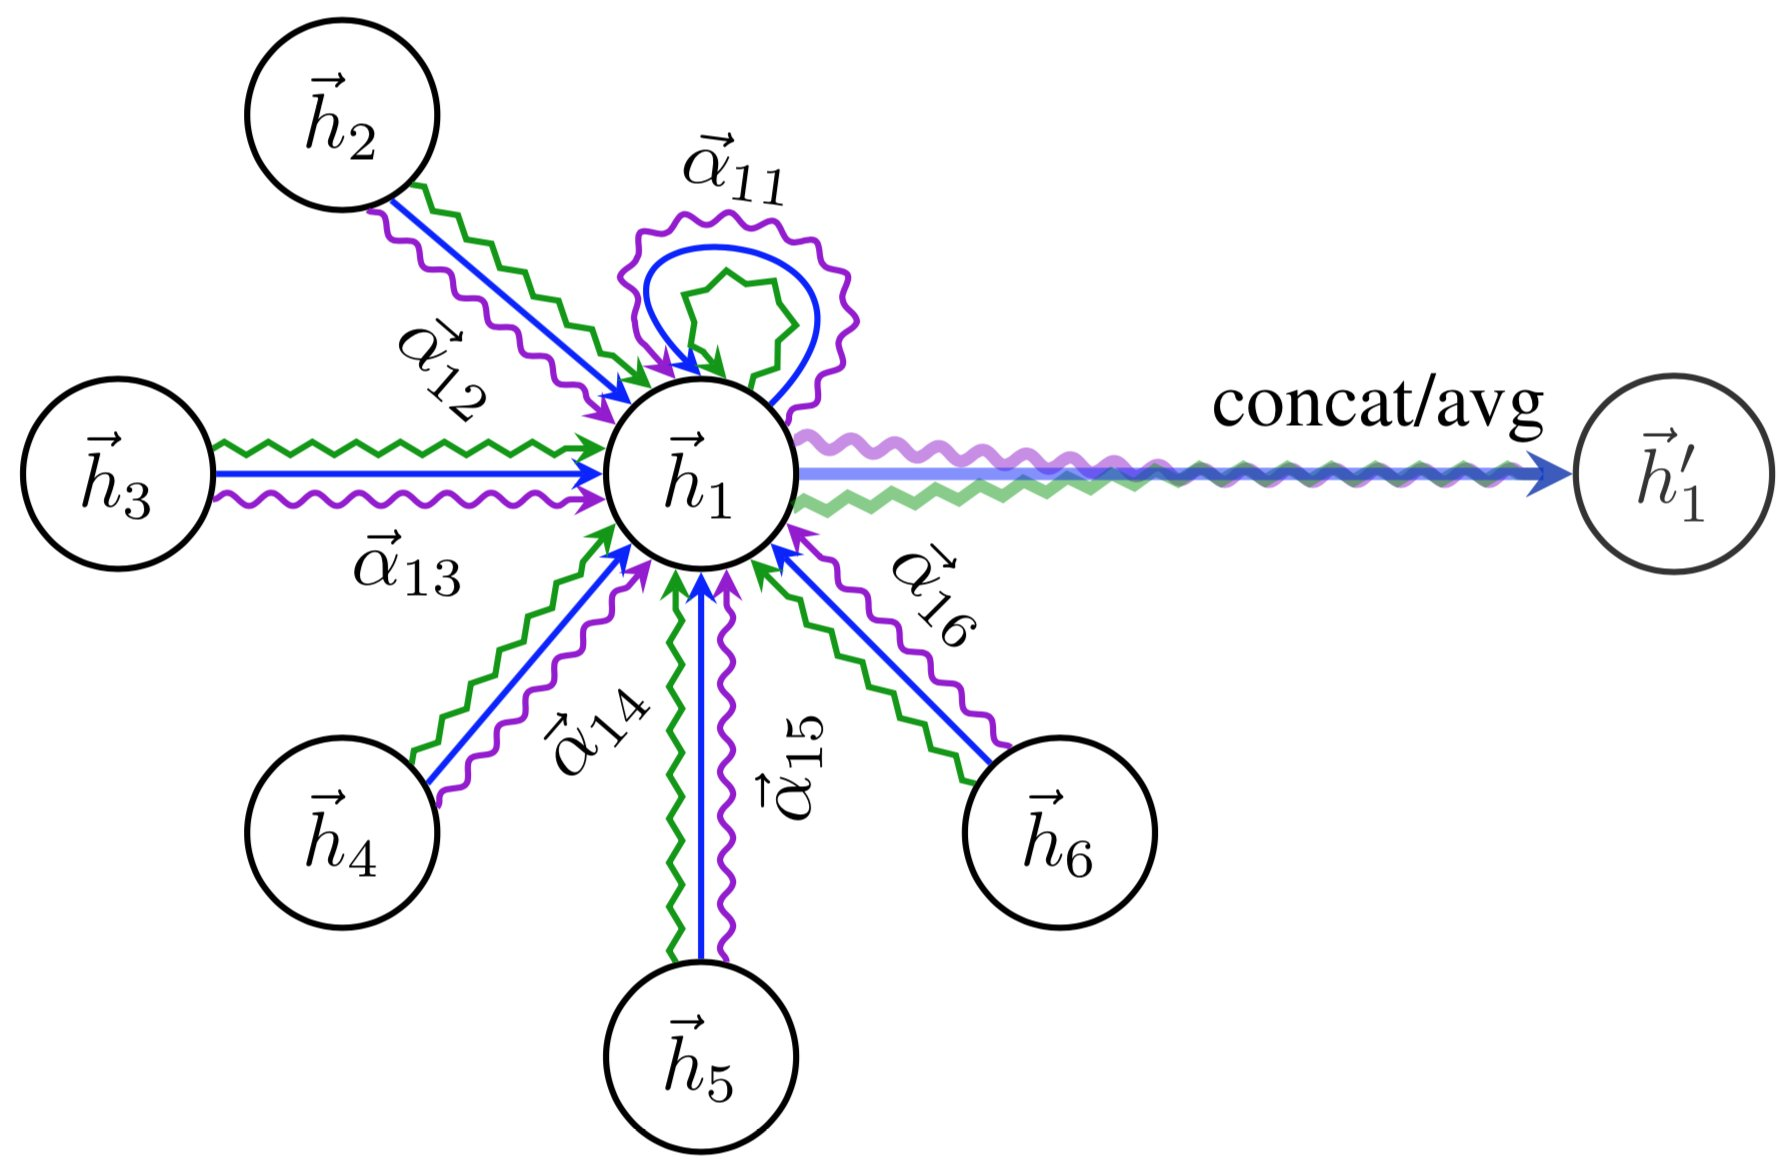

In [0]:
from IPython.display import Image, display
display(Image(filename='gat.jpg', width=850))

In [0]:
class GraphAttention(nn.Module):

    def __init__(self, in_features, out_features, dropout, alpha, init='xavier', concat=True):
        super(GraphAttention, self).__init__()
        
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat
                
        self.W = nn.Parameter(nn.init.xavier_normal_(torch.Tensor(in_features, out_features).type(torch.cuda.FloatTensor if use_gpu else torch.FloatTensor), gain=np.sqrt(2.0)), requires_grad=True)
        self.a1 = nn.Parameter(nn.init.xavier_normal_(torch.Tensor(out_features, 1).type(torch.cuda.FloatTensor if use_gpu else torch.FloatTensor), gain=np.sqrt(2.0)), requires_grad=True)
        self.a2 = nn.Parameter(nn.init.xavier_normal_(torch.Tensor(out_features, 1).type(torch.cuda.FloatTensor if use_gpu else torch.FloatTensor), gain=np.sqrt(2.0)), requires_grad=True)

        self.leakyrelu = nn.LeakyReLU(self.alpha)
        
        if init == 'uniform':
            print("| Uniform Initialization")
            self.init_uniform()
        elif init == 'xavier':
            print("| Xavier Initialization")
            self.init_xavier()
        else:
            raise NotImplementedError
            

    def init_uniform(self):
        stdv = 1. / math.sqrt(self.W.size(1))
        self.W.data.uniform_(-stdv, stdv)
        self.a1.data.uniform_(-stdv, stdv)
        self.a2.data.uniform_(-stdv, stdv)

    def init_xavier(self):
        nn.init.xavier_normal_(self.W.data, gain=0.02) # Implement Xavier Uniform
        nn.init.xavier_normal_(self.a1.data, gain=0.02) # Implement Xavier Uniform
        nn.init.xavier_normal_(self.a2.data, gain=0.02) # Implement Xavier Uniform

    def forward(self, input, adj):
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        
        h = torch.mm(input, self.W)
        N = h.size()[0]

        f_1 = torch.matmul(h, self.a1)
        f_2 = torch.matmul(h, self.a2)
        e = self.leakyrelu(f_1 + f_2.transpose(0,1))

        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, h)
        
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime
        

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'

### GAT Model

You have to build the GAT model.

In [0]:
class GAT(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, init, alpha, nheads):
        super(GAT, self).__init__()
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        
        self.dropout = dropout

        self.attentions = [GraphAttention(nfeat, nhid, dropout=dropout, init=init, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_att = GraphAttention(nhid * nheads, nclass, dropout=dropout, init=init, alpha=alpha, concat=False)
    
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

    def forward(self, x, adj):
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_att(x, adj))
        
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        return F.log_softmax(x, dim=1)

### Training
Next we run the training.


In [105]:
dataset = 'cora' 
num_hidden = 8 # number of features
dropout = 0.6 # dropout
weight_decay = 5e-4 # weight decay
init_type = 'xavier' # [uniform | xavier]
        
lr = 5e-3 # initial learning rate
optimizer_type = 'adam' # [sgd | adam]
epoch = 800 # number of training epochs
lr_decay_epoch = 5000 # multiply by a gamma every set iter
nb_heads = 8 # number of head attentions
alpha = 0.2 # Alpha value for the leaky_relu'


# Data upload
adj, features, labels, idx_train, idx_val, idx_test = load_data(path=dataroot, dataset=dataset)

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if use_gpu:
    torch.cuda.manual_seed(42)

optimizer = None
best_acc = 0


# Define the model and optimizer
print("| Constructing Attention model...")
model = GAT(
        nfeat = features.shape[1],
        nhid = num_hidden,
        nclass = int(labels.max().item()) + 1,
        dropout = dropout,
        nheads = nb_heads,
        alpha = alpha,
        init = init_type
)


if (optimizer_type == 'sgd'):
    optimizer = optim.SGD(
            model.parameters(),
            lr = lr,
            weight_decay = weight_decay,
            momentum = 0.9
    )
elif (optimizer_type == 'adam'):
    optimizer = optim.Adam(
            model.parameters(),
            lr = lr,
            weight_decay = weight_decay
    )
else:
    raise NotImplementedError

if use_gpu:
    model.cuda()
    features, adj, labels, idx_train, idx_val, idx_test = \
        list(map(lambda x: x.cuda(), [features, adj, labels, idx_train, idx_val, idx_test]))

features, adj, labels = list(map(lambda x : Variable(x), [features, adj, labels]))

if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')

save_point = os.path.join('./checkpoint', dataset)

if not os.path.isdir(save_point):
    os.mkdir(save_point)

# Main code for training
if __name__ == "__main__":
    print("\n[STEP 2] : Obtain (adjacency, feature, label) matrix")
    print("| Adjacency matrix : {}".format(adj.shape))
    print("| Feature matrix   : {}".format(features.shape))
    print("| Label matrix     : {}".format(labels.shape))

    # Training
    print("\n[STEP 3] : Training")
    for epoch in range(1, epoch+1):
        train(model, 'gat', adj, features, labels, idx_train, idx_val, optimizer, epoch, lr, lr_decay_epoch, save_point)
    print("\n=> Training finished!")


[STEP 1]: Upload cora dataset.
./planetoid/data/ind.cora.x
./planetoid/data/ind.cora.y
./planetoid/data/ind.cora.tx
./planetoid/data/ind.cora.ty
./planetoid/data/ind.cora.allx
./planetoid/data/ind.cora.ally
./planetoid/data/ind.cora.graph
| # of nodes : 2708
| # of edges : 1252.6696352573126
| # of features : 1433
| # of clases   : 7
| # of train set : 140
| # of val set   : 500
| # of test set  : 1000
| Constructing Attention model...
| Xavier Initialization
| Xavier Initialization
| Xavier Initialization
| Xavier Initialization
| Xavier Initialization
| Xavier Initialization
| Xavier Initialization
| Xavier Initialization
| Xavier Initialization

[STEP 2] : Obtain (adjacency, feature, label) matrix
| Adjacency matrix : torch.Size([2708, 2708])
| Feature matrix   : torch.Size([2708, 1433])
| Label matrix     : torch.Size([2708])

[STEP 3] : Training
=> Training Epoch #800 : lr = 0.0045 | Training acc :  85.71% | Best acc : 80.60%
=> Training finished!


### Test


We now evaluate the performance of the GAT.

In [106]:
adj, features, labels, idx_train, idx_val, idx_test = load_data(path=dataroot, dataset=dataset)

print("\n[STEP 2] : Obtain (adjacency, feature, label) matrix")
print("| Adjacency matrix : {}".format(adj.shape))
print("| Feature matrix   : {}".format(features.shape))
print("| Label matrix     : {}".format(labels.shape))

load_model = torch.load(os.path.join('./checkpoint', dataset, '%s.t7' %('gat')))
model = load_model['model'].cpu()
acc_val = load_model['acc']

if use_gpu:
    _, features, adj, labels, idx_test = \
            list(map(lambda x: x.cuda(), [model, features, adj, labels, idx_test]))


if __name__ == "__main__":
    test(model, adj, features, labels, idx_test)


[STEP 1]: Upload cora dataset.
./planetoid/data/ind.cora.x
./planetoid/data/ind.cora.y
./planetoid/data/ind.cora.tx
./planetoid/data/ind.cora.ty
./planetoid/data/ind.cora.allx
./planetoid/data/ind.cora.ally
./planetoid/data/ind.cora.graph
| # of nodes : 2708
| # of edges : 1252.6696352573126
| # of features : 1433
| # of clases   : 7
| # of train set : 140
| # of val set   : 500
| # of test set  : 1000

[STEP 2] : Obtain (adjacency, feature, label) matrix
| Adjacency matrix : torch.Size([2708, 2708])
| Feature matrix   : torch.Size([2708, 1433])
| Label matrix     : torch.Size([2708])

[STEP 4] : Testing
torch.Size([1000, 7])
torch.Size([1000])
| Validation acc : 80.60000000000001%
| Test acc : 80.60000000000001%



# Part 2: Theoretical questions (30%)

Please answer the following theoretical questions in a cell below each respective question.

a. What is the motivation for utilising self-attention in GATs instead of the GCN convolutional operator?

- Your answers here.

b. Explain multi-head attention in the context of GATs and provide a reason for why we elect to use it instead of the single-head baseline variant.

- Your answers here.